# Signature MMD Two-Sample Statistical Tests

## Uncontrolled Environment

### Andrew Alden, Blanka Horvath, Zacharia Issa

## Table of Contents:
* [Model Setup](#env-setup)
* [Two-Sample Hypothesis Test](#two-sample)
* [Lead-Lag](#leadlag)

In [1]:
import os
os.getcwd()
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [ ]:
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import pickle
from collections import defaultdict
import yfinance as yf

from src.utils.helper_functions.plot_helper_functions import make_grid, golden_dimensions
from src.utils.helper_functions.global_helper_functions import get_project_root
from src.utils.plotting_functions import plot_dist_boxen, plot_dist
from src.mmd.distribution_functions import return_mmd_distributions, expected_type2_error, get_level_values, generate_error_probs_linear_kernel
from src.mmd.level_functions import lambda_k, level_k_contribution, mmd_est_k
from src.mmd.signature_functions import get_level_k_signatures_from_paths
from src.mmd.level_functions import lambda_k, gramda_k
from src.mmd.mmd import SigKernel, RBFKernel, LinearKernel

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
def lead_lag_transformation(path):
    print(path.shape)
    if type(path) == list:
        n = len(path)
    else:
        n = path.shape[1]
        
    dt = path[0, -1, 1]/(n-1) * 1/2
    
    lead_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    lag_path = np.zeros((path.shape[0], path.shape[1]*2 + 1, path.shape[-1]))
    
    for i in range(1, int(2*n)):
        
        if i % 2 == 0:            
            lead_path[:, i, :] = np.concatenate((path[:, int((i+2)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int(i/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            
        else:
            lead_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)
            lag_path[:, i, :] = np.concatenate((path[:, int((i+1)/2 - 1), 0][:, None], (i-1)*dt*np.ones(path.shape[0])[:, None]), axis=1)

    lead_path[:, 0, :] = lead_path[:, 1, :]
    return lead_path[:, 1:-1, :], lag_path[:, 1:-1, :], np.concatenate((lead_path[:, 1:-1, :1], lag_path[:, 1:-1, :]), axis=2)

### Model Setup <a class="anchor" id="env-setup"></a>

In [25]:
tech_tickers = ['AAPL', 'META', 'NFLX', 'GOOG', 'CRM']
tech_dfs = []
for ticker_symbol in tech_tickers:
    
    ticker = yf.Ticker(ticker_symbol)
    historical_data = ticker.history(period="max", interval="1d")
    historical_data.index = historical_data.index.tz_convert(None)
    historical_data.index = pd.to_datetime(historical_data.index)
    spc_df = historical_data['Close'].to_frame()
    spc_df['ret'] = ((spc_df['Close'].shift(-1) - spc_df['Close'])/spc_df['Close'])
    spc_df = spc_df.dropna()
    spc_df = spc_df.loc[(spc_df.index >= np.datetime64('2014-09-10T00:00:00'))]
    spc_df = spc_df.loc[(spc_df.index <= np.datetime64('2024-09-08T00:00:00'))]
    tech_dfs.append(spc_df)

    
consumer_tickers = ['NSRGY', 'PEP', 'NKE', 'WMT', 'PG']
consumer_dfs = []
for ticker_symbol in consumer_tickers:
    
    ticker = yf.Ticker(ticker_symbol)
    historical_data = ticker.history(period="max", interval="1d")
    historical_data[['Open', 'High', 'Low', 'Close', 'Volume']].head(5)
    historical_data.index = historical_data.index.tz_convert(None)
    historical_data.index = pd.to_datetime(historical_data.index)
    spc_df = historical_data['Close'].to_frame()
    spc_df['ret'] = ((spc_df['Close'].shift(-1) - spc_df['Close'])/spc_df['Close'])
    spc_df = spc_df.dropna()
    spc_df = spc_df.loc[(spc_df.index >= np.datetime64('2014-09-10T00:00:00'))]
    spc_df = spc_df.loc[(spc_df.index <= np.datetime64('2024-09-08T00:00:00'))]
    consumer_dfs.append(spc_df)


In [37]:
def convert_to_time(x):
    days, hours, minutes = x.days, x.seconds // 3600, x.seconds // 60 % 60
    return days + hours/24 + minutes/1440


def generate_paths(df_list, col_name):
    
    starting_index = 0
    j = 0
    k = 0
    df_i = 0
    while j < 1000:
        try:
            initial_date = df_list[df_i].index[starting_index + (k*15)]
            X = df_list[df_i].loc[df_list[df_i].index >= initial_date][col_name][:15].to_frame()
            X['t'] = pd.to_timedelta((X.index.values - X.index.values[0]))
            X['t'] = X['t'].apply(convert_to_time)
            X['t'] = X['t'] / X['t'][-1]
            X = np.asarray(X)
            X[:, :1] = X[:, :1] - X[0, 0]
            if (j == 0) and (df_i == 0):
                paths = np.asarray(X)[None, ...]
                j += 1
            else:
                try:
                    paths = np.concatenate((paths, np.asarray(X)[None, ...]), axis=0)
                    j += 1
                except:
                    pass
            k += 1
        except:
            if df_i == len(df_list):
                break
            j = 0
            k = 0
            df_i += 1
    return paths

In [38]:
h0_paths = generate_paths(tech_dfs, 'ret')
h1_paths = generate_paths(consumer_dfs, 'ret')
if h0_paths.shape != h1_paths.shape:
    s = np.min([h0_paths.shape[0], h1_paths.shape[0]])
    h0_paths = h0_paths[:s, ...]
    h1_paths = h1_paths[:s, ...]
h0_paths = torch.Tensor(h0_paths).to(device=device)
h1_paths = torch.Tensor(h1_paths).to(device=device)

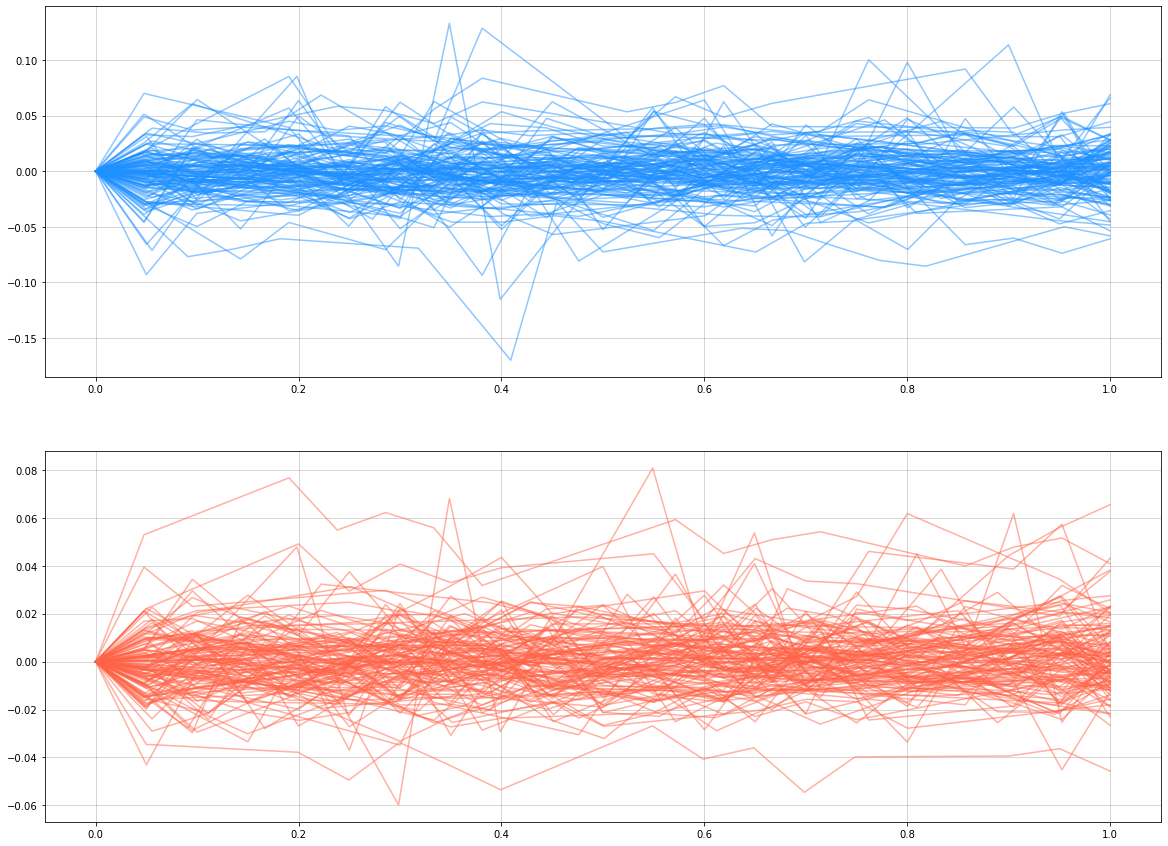

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
for i in range(0, 125):
    ax[0].plot(h0_paths[i, :, 1:].cpu(), h0_paths[i, :, :1].cpu(), color='dodgerblue', alpha=0.5)
    ax[1].plot(h1_paths[i, :, 1:].cpu(), h1_paths[i, :, :1].cpu(), color='tomato', alpha=0.5)
ax[0].grid(True, color='black', alpha=0.2)
ax[1].grid(True, color='black', alpha=0.2)

plt.show()

### Two-Sample Hypothesis Test <a class="anchor" id="two-sample"></a>

In [41]:
frac = 0.8
train_len = int(h0_paths.shape[0]*frac)
test_len = h0_paths.shape[0] - train_len

In [43]:
shuffled_indices = torch.randperm(h0_paths.shape[0])
h0_paths_shuffled = h0_paths[shuffled_indices, ...]
h1_paths_shuffled = h1_paths[shuffled_indices, ...]

In [45]:
h0_paths_train = h0_paths_shuffled[:train_len, ...]
h0_paths_test = h0_paths_shuffled[train_len:, ...]
h1_paths_train = h1_paths_shuffled[:train_len, ...]
h1_paths_test = h1_paths_shuffled[train_len:, ...]
print(h0_paths_train.shape)

torch.Size([668, 15, 2])


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:27<00:00,  5.70it/s]


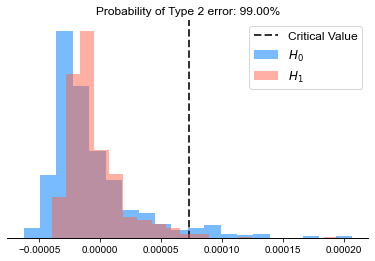

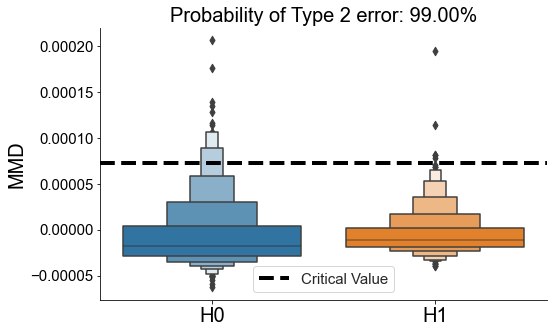

In [46]:
dyadic_order  = 0
static_kernel = LinearKernel()
signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1
h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths_train), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths_train), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_linear_noscaling.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

#### RBF Kernel, No Scaling

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


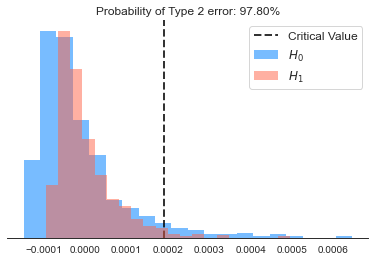

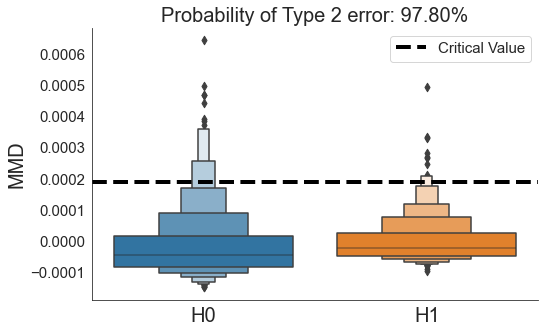

In [48]:
dyadic_order  = 0
scaling = 1
static_kernel = RBFKernel(sigma=1, scaling=scaling)

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1
h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths_train), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths_train), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)
df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_rbf_noscaling.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

#### RBF Kernel, Scaling

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:44<00:00,  4.78it/s]


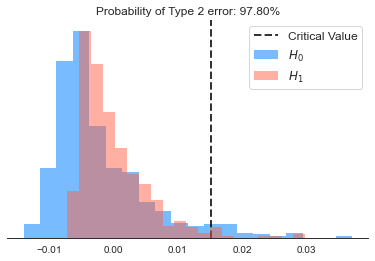

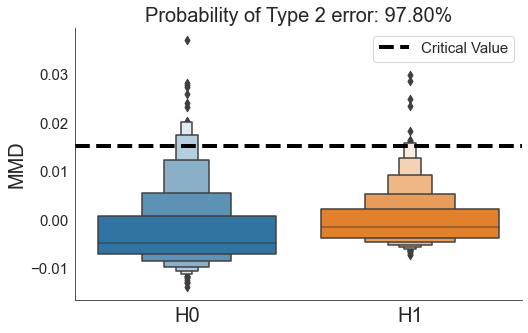

In [50]:
dyadic_order  = 0
scaling = 5
static_kernel = RBFKernel(sigma=1, scaling=scaling)
signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1
h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h0_paths_train), 
    torch.multiply(torch.Tensor([scaling, 1]).to(device=device), h1_paths_train), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)

plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)
df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_rbf_scaling_{5}.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

### Lead-Lag  <a class="anchor" id="leadlag"></a>

In [52]:
h0_paths_ll_shuffled = torch.Tensor(lead_lag_transformation(np.asarray(h0_paths_shuffled[:, :, :].cpu()))[-1]).to(device=device)
h1_paths_ll_shuffled = torch.Tensor(lead_lag_transformation(np.asarray(h1_paths_shuffled[:, :, :].cpu()))[-1]).to(device=device)

(835, 15, 2)
(835, 15, 2)


In [53]:
h0_paths_train_ll = h0_paths_ll_shuffled[:train_len, ...]
h0_paths_test_ll = h0_paths_ll_shuffled[train_len:, ...]
h1_paths_train_ll = h1_paths_ll_shuffled[:train_len, ...]
h1_paths_test_ll = h1_paths_ll_shuffled[train_len:, ...]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [03:22<00:00,  2.47it/s]


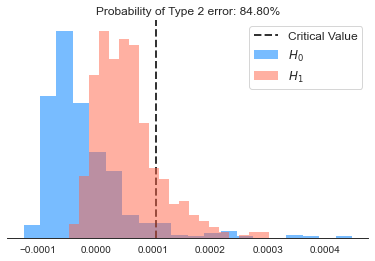

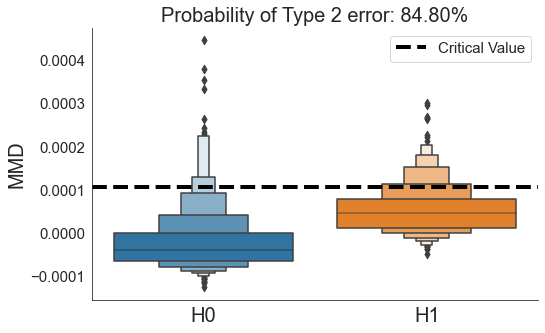

In [54]:
dyadic_order  = 0
static_kernel = LinearKernel()

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h0_paths_train_ll), 
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h1_paths_train_ll), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)


plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_linear_noscaling_leadlag.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

#### RBF, No Scaling

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:27<00:00,  1.87it/s]


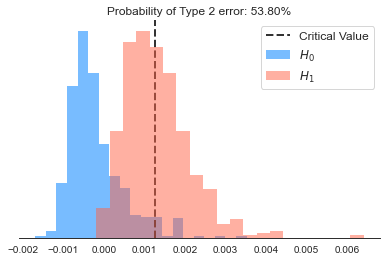

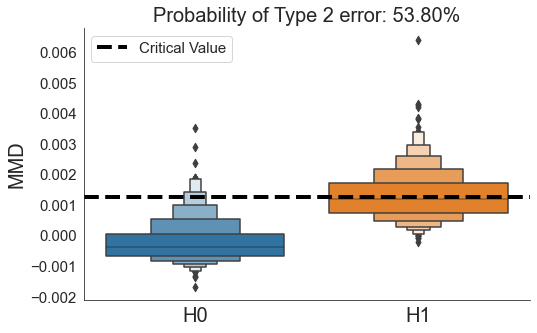

In [56]:
dyadic_order  = 0
static_kernel = RBFKernel(sigma=0.5, scaling=1)

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h0_paths_train_ll), 
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h1_paths_train_ll), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)


plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_rbf_noscaling_leadlag.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

#### RBF, Scaling

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [36:20<00:00,  4.36s/it]


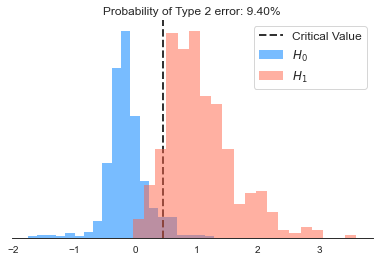

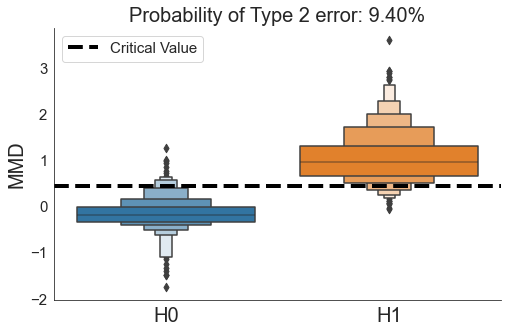

In [58]:
dyadic_order  = 0
scaling = 5
static_kernel = RBFKernel(sigma=0.5, scaling=scaling)

signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

n_atoms   = 500
n_paths   = 128
alpha = 0.05
scaling = 1

h0_dists, h1_dists = return_mmd_distributions(
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h0_paths_train_ll), 
    torch.multiply(torch.Tensor([scaling, scaling, 1.0]).to(device=device), h1_paths_train_ll), 
    signature_kernel.compute_mmd, 
    n_atoms=n_atoms, 
    batch_size=n_paths, 
    estimator='ub'
)


plot_dist(h0_dists, h1_dists, n_atoms, alpha, svg=True)

df = pd.DataFrame({'H': ['H0' for _ in range(len(h0_dists))] + ['H1' for _ in range(len(h1_dists))], 'MMD': h0_dists + h1_dists})
crit_val = np.sort(np.asarray(h0_dists))[int(n_atoms*(1-alpha))]    
title = f"Probability of Type 2 error: {100*expected_type2_error(torch.tensor(h1_dists), crit_val):.2f}%"
filename = f'real_world_type2_rbf_scaling_{5}_leadlag.svg'
plot_dist_boxen(df, 'H', 'MMD', crit_val=crit_val, title=title, y_label='MMD', svg=True, showfliers=True, log_scale=False, filename=filename)

### Permutation Test

In [59]:
dyadic_order  = 0
scaling = 5
static_kernel = RBFKernel(sigma=0.5, scaling=scaling)
signature_kernel = SigKernel(static_kernel=static_kernel, dyadic_order=dyadic_order)

alpha = 0.05
statistic = signature_kernel.compute_mmd(h0_paths_test_ll, h1_paths_test_ll, estimator='ub').cpu().item()
null_dists = []
data_test = torch.cat((h0_paths_test_ll, h1_paths_test_ll), axis=0)
for i in tqdm(range(2000)):
    rand_indices = torch.randperm(data_test.shape[0])
    p1 = data_test[rand_indices[:test_len], ...]
    p2 = data_test[rand_indices[test_len:], ...]
    null_dists.append(signature_kernel.compute_mmd(p1, p2, estimator='ub').cpu().item())
crit_val = np.sort(np.asarray(null_dists))[int(len(null_dists) * (1 - alpha))]
print(statistic)
print(crit_val)
print(statistic>crit_val)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [14:58<00:00,  2.23it/s]

0.9482421875
0.21453857421875
True
